# Hairsalon  Database


## About this notebook

This notebook was created to help with the initial analysis of the hair salon database. Its purpose is to select the model predictors from the hairsalon database and to engineer additional predictors.


In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import workdays as wd  #packahe used to calculate diff business days
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
import math
sns.set(style="darkgrid")
ROOT_PATH="C:/Users/moshe/Documents/projectML/p1"
DATA_PATH = "%s/data/raw" % ROOT_PATH
DB_FILE = "%s/hairsalon.db" % DATA_PATH
import sqlite3 as sql3
db=sql3.connect(DB_FILE)

In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################

#### List the name of the tables on the database 
def listTables():
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    res = cur.fetchall()
    cur.close()
    db.close()
    return(res)

#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()

#### Generate a view based on the provided SQL query
def createView(viewname, vquery):
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    query="""SELECT * FROM sqlite_master WHERE type='view'"""
    listview=readSQL(query)
    df=listview[listview['name']==viewname]
    if len(df)==1:
        query='drop view {}'.format(viewname)
        execquery(query)
    view = 'CREATE VIEW {} AS {}'.format(viewname,vquery)
    cur = db.cursor()
    cur.execute(view)
    cur.close()
    db.close()

def execquery (query):
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute(query)
    cur.close()
    db.close()
     

<h1> import from csv data into sqltables  </h1>

In [3]:
import pandas as pd
file_tuple=("Client Cancellations0","Future Bookings (All Clients)0","No-Show Report0",
            "Product Listing (Retail)0","Receipt Transactions0","Service Listing0")
table_tuple=("cancellation","futurebooking","noshow","product","receipt","service")
tableiter=iter(table_tuple)

#loop over csv files and crate a correpsonding table for each file 
for f in file_tuple:
    file=f'{DATA_PATH}/{f}.csv'
    df=pd.read_csv(file)
    #rename columns remove spaces and lower allcharacters
    df.rename(columns=lambda x:x.replace(" ",""),inplace=True)
    df.rename(columns=lambda x:x.lower(),inplace=True)
    df.to_sql(next(tableiter),db,if_exists='replace',index=False)
    db.commit()

<h2> exploring tables by various queries

In [4]:
cancellations = readSQL('''SELECT * FROM cancellation''')
cancellations.head()

,canceldate,code,service,staff,bookingdate,canceledby,days
0,05/22/2018,MASA01,CFC,JOANNE,05/24/2018,ADMIN,2.0
1,06/27/2018,MASA01,CBAL,KELLY,06/27/2018,ADMIN,0.0
2,07/03/2018,MASA01,SHCM,BECKY,07/10/2018,BECKY,7.0
3,07/10/2018,MASA01,SHCC,JJ,07/11/2018,KELLY,1.0
4,07/24/2018,TRUA01,SHCM,KELLY,07/24/2018,TANYA,0.0


In [5]:
futurebookings=readSQL('''SELECT * FROM futurebooking''')
futurebookings.head()

,code,staff,service,date,time,timeint
0,JUNJ01,JJ,CON,03/14/2018,3:50:00 PM,950
1,NORJ01,JJ,SHCM,03/14/2018,4:00:00 PM,960
2,CORS01,JJ,SHCW,03/15/2018,2:10:00 PM,850
3,KERT01,JJ,SHCW,03/15/2018,10:00:00 AM,600
4,LEHJ01,JJ,SHCM,03/15/2018,6:00:00 PM,1080


In [6]:
receipts=readSQL('''SELECT * FROM receipt''')
receipts.head()

,receipt,date,description,client,staff,quantity,amount,gst,pst
0,10,03/15/2018,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56
1,100,04/05/2018,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60
2,1000,06/09/2018,Consultation,PEDM01,JJ,1,0.0,0.00,0.00
3,1001,06/09/2018,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40
4,1003,06/09/2018,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20


In [7]:
noshows=readSQL('''SELECT * FROM noshow''')
noshows.head()

,date,code,service,staff
0,04/13/2018,None,SHCW,JJ
1,07/27/2018,AMAB01,SHCM,KELLY
2,06/07/2018,APPS01,SBD,KELLY
3,06/05/2018,ASIS01,SHCW,KELLY
4,05/31/2018,BISD01,CON,SINEAD


In [8]:
products=readSQL('''SELECT * FROM product''')
products.head()

,isactive,code,description,supplier,brand,category,price,onhand,minimum,maximum,cost,cog,ytd,package
0,1,AGBALANCE335M,AG balance 355ml,VENUS,AG,RETAIL,30.0,2,2,2,0.0,0.0,27.0,0
1,1,AGBOOST355ML,AG Boost 355ml,VENUS,AG,RETAIL,30.0,3,2,2,18.0,54.0,0.0,0
2,1,AGCLOUD107ML,AG Cloud 107ml,VENUS,AG,RETAIL,26.0,4,2,2,15.6,62.4,23.4,0
3,1,AGDRYLIFT44ML,AG Dry Lift 44ml,VENUS,AG,RETAIL,24.0,1,2,2,14.4,14.4,43.2,0
4,1,AGREMEDY148ML,AG Remedy 148ml,VENUS,AG,RETAIL,26.0,3,2,2,15.6,46.8,0.0,0


In [9]:
services=readSQL('''SELECT * FROM service''')
services.head()

,isactive,code,desc,cate,price,cost
0,1,CAL,accent lights,COLOR,0,10
1,1,CALC,Accent lights and color,COLOR,0,10
2,1,CAS,Color additional service,COLOR,0,10
3,1,CBAL,Balayage,COLOR,0,10
4,1,CCAMO,Men's camo color,COLOR,45,5


In [10]:
#SQLITE DB date and time are saved as text values - the code below updates the format in the DB
#converts format date MM/DD/YYYY =>ISO FORMAT 8601 YYYY-DD-MM
#converts format date 3:50:0 PM =>ISO FORMAT HH:MM:SS
import datetime as dt
cancellations['canceldate']=pd.to_datetime(cancellations['canceldate'],format="%m/%d/%Y")
cancellations['canceldate'] = cancellations['canceldate'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
cancellations['bookingdate']=pd.to_datetime(cancellations['bookingdate'],format="%m/%d/%Y")
cancellations['bookingdate'] = cancellations['bookingdate'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
cancellations.to_sql('cancellation',db,if_exists='replace',index=False)

futurebookings['date']=pd.to_datetime(futurebookings['date'],format="%m/%d/%Y")
futurebookings['date'] = futurebookings['date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
futurebookings['time']=pd.to_datetime(futurebookings['time'],infer_datetime_format=True)
futurebookings['time'] = futurebookings['time'].apply(lambda x: dt.datetime.strftime(x, '%H:%M:%S'))
futurebookings.to_sql('futurebooking',db,if_exists='replace',index=False)

receipts['date']=pd.to_datetime(receipts['date'],format="%m/%d/%Y")
receipts['date'] = receipts['date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
receipts.to_sql('receipt',db,if_exists='replace',index=False)

#converts format date MM/DD/YY =>ISO FORMAT 8601 YYYY-DD-MM
noshows['date']=pd.to_datetime(noshows['date'],format="%m/%d/%Y")
noshows['date'] = noshows['date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
noshows.to_sql('noshow',db,if_exists='replace',index=False)

In [11]:
query = """SELECT MIN(canceldate), MAX(canceldate), MIN(bookingdate), Max (bookingdate),min(days),max(days),count(*)
         FROM cancellation"""
resquery = readSQL(query)
resquery

,MIN(canceldate),MAX(canceldate),MIN(bookingdate),Max (bookingdate),min(days),max(days),count(*)
0,2018-03-27,2018-07-28,2018-03-29,2018-09-21,-37.0,66.0,243


In [12]:
query = """SELECT MIN(date), MAX(date), count(*)
         FROM noshow"""
resquery = readSQL(query)
resquery

,MIN(date),MAX(date),count(*)
0,2018-03-14,2018-07-29,60


In [13]:
query = """SELECT MIN(date), MAX(date), Min(Time),Max(time), count(*)
         FROM futurebooking"""
resquery = readSQL(query)
resquery

,MIN(date),MAX(date),Min(Time),Max(time),count(*)
0,2018-03-14,2019-02-15,08:00:00,19:30:00,1906


In [14]:
query = """SELECT MIN(date), MAX(date),MIN(amount),MAX(amount), count(*)
         FROM receipt """
resquery = readSQL(query)
resquery

,MIN(date),MAX(date),MIN(amount),MAX(amount),count(*)
0,2018-03-15,2018-07-29,-52.0,300.0,1934


In [15]:
#A receipt can count several sub-receipts for different services or products
query = """SELECT count(*), count(distinct receipt) 
         FROM receipt """
resquery = readSQL(query)
resquery

,count(*),count(distinct receipt)
0,1934,1436


In [16]:
#nb of sub-receipts vary from one to six
query = """
SELECT count(*) receipts, subreceiptcnt nbsubreceipts FROM
(SELECT count(*) subreceiptcnt, receipt 
         FROM receipt group by receipt)
group by subreceiptcnt"""
resquery = readSQL(query)
resquery

,receipts,nbsubreceipts
0,1047,1
1,309,2
2,57,3
3,18,4
4,4,5
5,1,6


In [17]:
#All services listed in futurebooking are services defined in service table [same number of rows]
query= """select count(*) from futurebooking fb
        inner join service s on fb.service=s.code"""
resquery = readSQL(query)
resquery

,count(*)
0,1906


In [18]:
#part of the receipts are for services
query= """select count(*) from receipt r
        inner join service s on r.description=s.desc
        WHERE r.description is NOT NULL
        """
resquery = readSQL(query)
resquery

,count(*)
0,1758


In [19]:
#part of the receipts are for products
query= """select count(*) from receipt r
        inner join product p on r.description=p.description WHERE r.description is NOT NULL"""
resquery = readSQL(query)
resquery

,count(*)
0,173


In [20]:
#part of the receipts are not indicated with services or services
query= """select count(*) from receipt r 
        left join product p on r.description=p.description 
        left join service s on r.description=s.desc
        where p.description is NULL and s.desc is NULL"""
resquery = readSQL(query)
resquery

,count(*)
0,3


In [21]:
query="""select fb.*, s.desc description, s.cate category from futurebooking fb 
inner join service s on fb.service=s.code """
createView('vfb0',query)

In [22]:
#noshows  linked to a booking
query="""select n.* from noshow n
    inner join futurebooking fb  
    on n.date=fb.date and n.code=fb.code and n.service=fb.service and n.staff=fb.staff"""
resquery=readSQL(query)
resquery.shape

(59, 4)

In [23]:
#there is a missing customer we will need to remove it since we cannot determine its noshow indicator, its receipt, etc.. 
#since we cannot link it with table receipt noshow and cancellation 
query="""select * from futurebooking fb  
    where code is null """
resquery=readSQL(query)
resquery

,code,staff,service,date,time,timeint
0,None,JJ,SHCW,2018-04-13,18:00:00,1080


#Verifying that there is not twice the same appointment by the same person on the same day for the same service 

In [24]:
query="""select count(*), fb.date,fb.code,fb.service,fb.staff from futurebooking fb 
      group by fb.date,fb.code,fb.service,fb.staff
      having count(*)>1"""
resquery=readSQL(query)
resquery.head()

,count(*),date,code,service,staff


Appointments were cancelled and booked on the same day by a customer 
A diffferent staff was assgined or maybe different service 
we might not take them into account as late cancellation
We need to understand the cause we will further investigate 
some appointments for the same person were cancelled twice or even 4 times !

In [25]:
query="""select fb.code, fb.staff,fb.service, fb.date from futurebooking fb inner join cancellation c
where fb.date=c.bookingdate and fb.code=c.code """
resquery=readSQL(query)
resquery.head()

,code,staff,service,date
0,SARA01,JJ,SHCM,2018-04-04
1,HUDM01,JJ,CHLFH,2018-04-08
2,STEM01,BECKY,SHCW,2018-04-21
3,BUSM01,SINEAD,SHCW,2018-04-26
4,MOIB01,SINEAD,SHCW,2018-04-26


In [26]:
#All services defined in table cancellation are defined in table services
query="""select  count(*) from vcancellation c where description is NULL"""
resquery=readSQL(query)
resquery

,count(*)
0,0


In [27]:
query="""select c.*, s.desc description, s.cate category from cancellation c 
inner join service s on c.service=s.code """
createView('vcancellation',query)

In [28]:
#All services defined in table futurebookings are defined in table services
query="""select  count(*) from vfb0 c where description is NULL"""
resquery=readSQL(query)
resquery

,count(*)
0,0


In [29]:
#create extended view of receipt 
query="""select r.*,s.code service, 'S' type, s.cate category 
            from receipt r inner join service s on r.description=s.desc
            where r.client <>'WALK-IN'
union all
            select r.*,p.code service, 'P' type, p.category category 
            from receipt r inner join product p on r.description=p.description
            where r.client <>'WALK-IN'
union all
            select r.*, NULL service, NULL type, NULL category
            from receipt r
            left join service s on r.description=s.desc
            left join product p on r.description=p.description 
            where s.desc IS NULL and p.description IS NULL and r.client <>'WALK-IN'"""
createView('vreceipt',query)
resquery=readSQL("""select * from vreceipt""")
resquery.head()

,receipt,date,description,client,staff,quantity,amount,gst,pst,service,type,category
0,10,2018-03-15,Women's hair cut,KERT01,JJ,1,82.0,4.10,6.56,SHCW,S,STYLE
1,100,2018-04-05,Women's hair cut,COOM01,SINEAD,1,70.0,3.50,5.60,SHCW,S,STYLE
2,1000,2018-06-09,Consultation,PEDM01,JJ,1,0.0,0.00,0.00,CON,S,MISC
3,1001,2018-06-09,Women's hair cut,BAIS01,KELLY,1,55.0,2.75,4.40,SHCW,S,STYLE
4,1003,2018-06-09,Women's hair cut,FRAL01,KELLY,1,65.0,3.25,5.20,SHCW,S,STYLE


In [30]:
cancellation=readSQL("""select * from cancellation""")
print('cancellation', len(cancellation))
futurebooking=readSQL("""select * from futurebooking""")
print('futurebooking',len(futurebooking))
noshow=readSQL("""select * from noshow""")
print('noshow',len(noshow))
receipt=readSQL("""select * from receipt""")
receipt.head()
print('receipt',len(receipt))

cancellation 243
futurebooking 1906
noshow 60
receipt 1934


In [31]:
query="""select * from vfb0"""
vfb0=readSQL(query)
vfb0.shape

(1906, 8)

In [32]:
vfb0.rename(columns={'code':'client'},inplace=True)
print('vfb0', len(vfb0))
vfb0.columns

vfb0 1906


Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category'],
      dtype='object')

In [33]:
vcancellation=readSQL("""select * from vcancellation""")
print('vcancellation', len(vcancellation))
vcancellation.columns

vcancellation 243


Index(['canceldate', 'code', 'service', 'staff', 'bookingdate', 'canceledby',
       'days', 'description', 'category'],
      dtype='object')

In [34]:
vcancellation.rename(columns={'bookingdate':'date','code':'client'},inplace=True)
vcancellation.columns

Index(['canceldate', 'client', 'service', 'staff', 'date', 'canceledby',
       'days', 'description', 'category'],
      dtype='object')

In [35]:
vreceipt=readSQL("""select * from vreceipt """)
len(vreceipt)

1934

In [36]:
vreceipt.columns

Index(['receipt', 'date', 'description', 'client', 'staff', 'quantity',
       'amount', 'gst', 'pst', 'service', 'type', 'category'],
      dtype='object')

In [37]:
noshow.rename(columns={'code':'client'},inplace=True)
noshow.columns

Index(['date', 'client', 'service', 'staff'], dtype='object')

In [38]:
vcancellation.isna().sum()

canceldate     0
client         0
service        0
staff          0
date           0
canceledby     0
days           2
description    0
category       0
dtype: int64

In [39]:
#future booking and past non cancelled bookings
vfb0.isna().sum()

client         1
staff          0
service        0
date           0
time           0
timeint        0
description    0
category       0
dtype: int64

In [40]:
noshow.isna().sum()

date       0
client     1
service    0
staff      0
dtype: int64

In [41]:
receipt.isna().sum()

receipt        0
date           0
description    3
client         0
staff          0
quantity       0
amount         0
gst            0
pst            0
dtype: int64

In [42]:
vreceipt.isna().sum()

receipt        0
date           0
description    3
client         0
staff          0
quantity       0
amount         0
gst            0
pst            0
service        3
type           3
category       9
dtype: int64

<h2> building final data set 

building data set of future and non cancelled bookings it includes no shows

We will suppress all bookings that occur after 2018-07-29 and the client code is null. No receipts are produced after this date (see MAX receipt date) Therefore we have no way of understanding what happened after this date 

In [43]:
query="""select * from vfb0 where (date <='2018-07-29' or date is NULL) and code is NOT null"""
createView('vfb',query)
vfb=readSQL("""select * from vfb""")
len(vfb)

1716

In [44]:
query="""select vfb.code client,vfb.staff,vfb.service, vfb.date, vfb.time,vfb.timeint, 
        description, category,
        CASE 
        WHEN (vfb.service IS NULL or vfb.staff IS NULL) or 
        (n.date IS NULL or n.code IS NULL or n.service IS NULL or n.staff IS NULL) THEN NULL 
        ELSE 1 END as noshowflag0 
        FROM vfb
            LEFT JOIN noshow n on vfb.date=n.date and vfb.code=n.code and vfb.service=n.service and vfb.staff=n.staff
            """
createView('vbooking0',query)

Checking customers for which no receipt was issued they are also marked as no-show

In [45]:
bookings=readSQL("""select a.client,a.staff,a.service, a.date, a.time,a.timeint, 
            a.description, a.category,
            CASE 
            WHEN a.noshowflag0 = 1 THEN 1
            WHEN (b.client IS NULL or b.date IS NULL ) THEN 1
            ELSE 0 END as noshowflag
            from vbooking0 a
            left join (select client,date, sum(amount) amt from vreceipt group by client,date) b 
            on a.client=b.client and a.date=b.date""")
bookings['canceldate']=None
bookings['canceledby']=None
bookings['latecancellation']=0
len(bookings)

1716

In [46]:
len(bookings[bookings['noshowflag']==1])

60

In [47]:
bookings.isna().sum()

client                 0
staff                  0
service                0
date                   0
time                   0
timeint                0
description            0
category               0
noshowflag             0
canceldate          1716
canceledby          1716
latecancellation       0
dtype: int64

<h4>building list of all cancellations including late minute cancellations

In [48]:
cancellations2=vcancellation.copy()
cancellations2['noshowflag']=0
cancellations2['deltabdays']=None
cancellations2=cancellations2[['client','staff','service','date','description','category',
                               'noshowflag','canceldate','canceledby','deltabdays']]
cancellations2.columns

Index(['client', 'staff', 'service', 'date', 'description', 'category',
       'noshowflag', 'canceldate', 'canceledby', 'deltabdays'],
      dtype='object')

In [49]:
print('cancellation', len(cancellations2))
print('booking',len(bookings))
print('noshow',len(noshow))
print('receipt',len(receipt))

cancellation 243
booking 1716
noshow 60
receipt 1934


In [50]:
cancellations2=cancellations2[cancellations2.canceldate <= '2018-07-28']
cancellations2.isna().sum()

client           0
staff            0
service          0
date             0
description      0
category         0
noshowflag       0
canceldate       0
canceledby       0
deltabdays     243
dtype: int64

<h6>calculating difference of business days to determine late cancellations that are equivalent to noshow

In [51]:
import datetime as dt
import workdays

#salon is open on all days execpt monday
wd.weekends=(0,) 
#ontorio holidays
holidays=[dt.date(2018,3,30),dt.date(2018,5,21),dt.date(2018,7,1)]
wd.weekends
delta=[]
for row in cancellations2.itertuples():
    sd=pd.to_datetime(row.canceldate).date()
    ed=pd.to_datetime(row.date).date()
    if sd==ed:
        nbwd=0
    else:
        nbwd=wd.networkdays(sd,ed,holidays)-1
    delta.append(nbwd)
cancellations2.deltabdays=delta
cancellations2.isna().sum()

client         0
staff          0
service        0
date           0
description    0
category       0
noshowflag     0
canceldate     0
canceledby     0
deltabdays     0
dtype: int64

In [52]:
cancellations2.head()

,client,staff,service,date,description,category,noshowflag,canceldate,canceledby,deltabdays
0,MASA01,JOANNE,CFC,2018-05-24,Color full color,COLOR,0,2018-05-22,ADMIN,2
1,MASA01,KELLY,CBAL,2018-06-27,Balayage,COLOR,0,2018-06-27,ADMIN,0
2,MASA01,BECKY,SHCM,2018-07-10,Men's hair cut,STYLE,0,2018-07-03,BECKY,6
3,MASA01,JJ,SHCC,2018-07-11,Children (under 12),STYLE,0,2018-07-10,KELLY,1
4,TRUA01,KELLY,SHCM,2018-07-24,Men's hair cut,STYLE,0,2018-07-24,TANYA,0


In [53]:
cancellations2.to_sql('cancellations2',db,if_exists='replace',index=False)


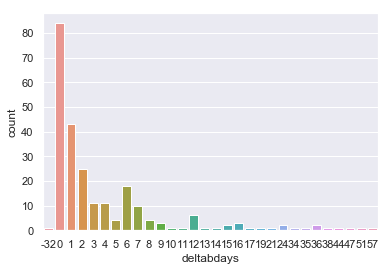

In [54]:
#indicates the number of business days between cancellation and appointment day
ax = sns.countplot(x="deltabdays", data=cancellations2)

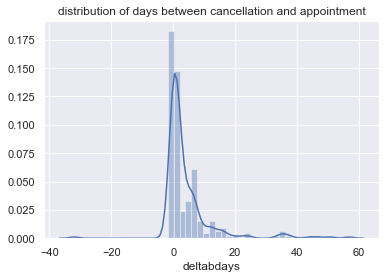

In [55]:
plt.title("distribution of days between cancellation and appointment")
ax = sns.distplot(cancellations2['deltabdays'])

In [56]:
cancellations2[(cancellations2.deltabdays<0)]

,client,staff,service,date,description,category,noshowflag,canceldate,canceledby,deltabdays
154,KOOM01,JJ,SHCW,2018-04-03,Women's hair cut,STYLE,0,2018-05-10,JJ,-32


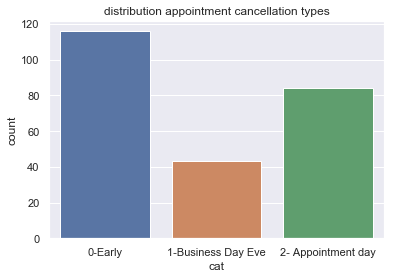

In [57]:
cancellations2['cat']='0-Early'
cancellations2.loc[cancellations2['deltabdays']==1,'cat']='1-Business Day Eve'
cancellations2.loc[cancellations2['deltabdays']==0,'cat']='2- Appointment day'
cancellations2['cat']=cancellations2['cat'].astype('category')
plt.title("distribution appointment cancellation types")
ax = sns.countplot(x="cat", data=cancellations2)

In [58]:
cancellations2["latecancellation"]=0
cancellations2["noshowflag"]=0
cancellations2.loc[((cancellations2.deltabdays==0) | (cancellations2.deltabdays==1)),"latecancellation"]=1
print('total cancellations',len(cancellations2))
print('late cancellation day',len(cancellations2[(cancellations2.latecancellation==1)]))
cancellations2.loc[(cancellations2.deltabdays==0),"noshowflag"]=1
print('cancellation done one day before appointment day',len(cancellations2[(cancellations2.latecancellation==1) & (cancellations2.noshowflag==0)]))
print('cancellation done on appointment day',len(cancellations2[(cancellations2.noshowflag==1)]))
cancellations2.columns

total cancellations 243
late cancellation day 127
cancellation done one day before appointment day 43
cancellation done on appointment day 84


Index(['client', 'staff', 'service', 'date', 'description', 'category',
       'noshowflag', 'canceldate', 'canceledby', 'deltabdays', 'cat',
       'latecancellation'],
      dtype='object')

In [59]:
#data frame of cancellations without no noshow includes late cancellations
cancellation3=cancellations2.copy()
cancellationearly=cancellation3[(cancellation3.latecancellation==0)]
cancellationnoshow=cancellation3[(cancellation3.noshowflag==1)]
cancellationeve=cancellation3[(cancellation3.noshowflag==0) & (cancellation3.latecancellation==1)]
len(cancellation3)

243

###### 

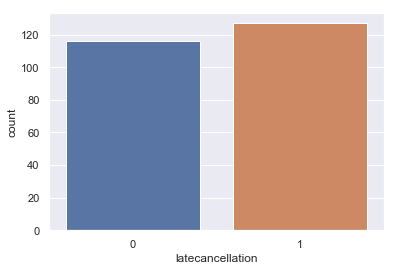

In [60]:
ax = sns.countplot(x="latecancellation", data=cancellation3)

<h6> concatenating effective bookings with cancellations done on the day  

In [61]:
print('cancellation no show',len(cancellationnoshow))
print('bookings',len(bookings))
bookings.columns

cancellation no show 84
bookings 1716


Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate', 'canceledby',
       'latecancellation'],
      dtype='object')

In [62]:
cancellationnoshow.columns

Index(['client', 'staff', 'service', 'date', 'description', 'category',
       'noshowflag', 'canceldate', 'canceledby', 'deltabdays', 'cat',
       'latecancellation'],
      dtype='object')

In [63]:
fbooking=pd.concat([bookings,cancellationnoshow.loc[:, cancellationnoshow.columns != 'deltabdays']
],sort=False)
len(fbooking)

1800

In [64]:
fbooking2=fbooking.copy()
fbooking2.dtypes

client               object
staff                object
service              object
date                 object
time                 object
timeint             float64
description          object
category             object
noshowflag            int64
canceldate           object
canceledby           object
latecancellation      int64
cat                  object
dtype: object

In [65]:
print('total number of appointments',len(fbooking2))
print('number of pure noshows', len(fbooking2[(fbooking2.noshowflag==1) & (fbooking2.latecancellation==0)]))
print('number of cancellation on appointement day', len(fbooking2[(fbooking2.noshowflag==1) & (fbooking2.latecancellation==1)]))
print('number of non cancelled appointments', len(fbooking2[(fbooking2.noshowflag==0)]))

total number of appointments 1800
number of pure noshows 60
number of cancellation on appointement day 84
number of non cancelled appointments 1656


In [66]:
fbooking2.isna().sum()

client                 0
staff                  0
service                0
date                   0
time                  84
timeint               84
description            0
category               0
noshowflag             0
canceldate          1716
canceledby          1716
latecancellation       0
cat                 1716
dtype: int64

In [67]:
#https://stackoverflow.com/questions/3806473/python-week-number-of-the-month
#week are starting on mondays
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    firstday = dt.replace(day=1)
    dayinmonth = dt.day
    adjusted_dayinmonth = dayinmonth + firstday.weekday()
    return int(ceil(adjusted_dayinmonth/7.0))

In [68]:
fbooking2['dayinweek']=pd.to_datetime(fbooking2['date']).apply(lambda x: x.weekday()).astype('float64')
fbooking2['week']=pd.to_datetime(fbooking2['date']).apply(week_of_month).astype('float64')
fbooking2['tdate']=pd.to_datetime(fbooking2['date'])
fbooking2['month']=pd.to_datetime(fbooking2['date']).apply(lambda x: x.month)
fbooking2['time01']=fbooking2['timeint'].apply(lambda x: 
                        ((x-fbooking2['timeint'].min())/(fbooking2['timeint'].max()-fbooking2['timeint'].min())))
fbooking2['ttime']=pd.to_datetime(fbooking2['time'])
fbooking2['hour']=fbooking2['ttime'].apply(lambda x: x.hour)
fbooking2.columns

Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate', 'canceledby',
       'latecancellation', 'cat', 'dayinweek', 'week', 'tdate', 'month',
       'time01', 'ttime', 'hour'],
      dtype='object')

<h4> building Customer variables based on past history<h4>
     Data is exported into database for using SQL JULIANDAY, SUM, ORDER BY etc... 

In [69]:
bookingtmp=fbooking2[['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate', 'canceledby',
       'latecancellation', 'tdate', 'month','week','dayinweek' ,'ttime',
       'hour']].copy()
bookingtmp.to_sql('bookingtmp0',db,if_exists='replace',index=False)

We assume that if there are (staff,date) combinations where there are only appointments that were canceled on the same day it means that the employee probably did no show up and he or the hair salon  cancelled his appointments and as a result it did not lead to a no-show. These appointments cannot be considered as no-show

In [70]:
query="""select a.date,a.staff, count(*) c, b.c latecount from bookingtmp0 a inner join 
(select date,staff,count(*) c from bookingtmp0 where latecancellation=1 group by date,staff) b 
on a.date=b.date and a.staff=b.staff
group by a.date,a.staff having count(*) = b.c
order by a.date,a.staff"""
df=readSQL(query)
df

,date,staff,c,latecount
0,2018-04-03,KELLY,1,1
1,2018-05-18,KELLY,1,1
2,2018-07-19,TANYA,1,1
3,2018-07-21,JOANNE,1,1
4,2018-07-27,TANYA,1,1


In [71]:
query="""select * from bookingtmp0"""
df1=readSQL(query)
dfmerged=df1.merge(df.loc[:,['date','staff']], on=['date','staff'],how='left', indicator=True)
dfmerged=dfmerged[dfmerged._merge!='both']
dfmerged.drop(['_merge'], axis=1).to_sql('bookingtmp',db,if_exists='replace',index=False)

In [72]:
query="""select a.*,
        case
        when a.client IS null then null
        when (b.firstdate IS NULL AND A.date=C.FIRSTDATE2) or (a.date=b.firstdate and c.firstdate2 is NULL) 
        or (a.date=MiN(b.firstdate,c.firstdate2))   THEN 1 
        else 0 END as firstapp,
        case
        when a.client IS null then null
        when a.date=b.firstdate THEN 1 
        else 0 END as newcustomer,
        case 
        when a.client IS null then null
        when a.date > b.firstdate THEN 1
        else 0 END existingcustomer,
        b.firstdate, c.firstdate2 from bookingtmp a 
left join (select client,MIN(date) firstdate from bookingtmp where noshowflag=0 and dayinweek<>0 group by client ) b
on a.client=b.client 
left join (select client,MIN(date) firstdate2 from bookingtmp where noshowflag=1 and dayinweek<>0 group by client ) c
on a.client=c.client
where dayinweek<>0 """
createView('vbookingtmp',query)

In [73]:
query="""select a.*
,IFNULL((select julianday(a.date)-julianday((select MAX(b.date) from vbookingtmp b
        where b.client=a.client and 
        b.noshowflag=0 and b.date < a.date))),0) deltadaysappt
,IFNULL((select julianday(a.date)-julianday((select MAX(b.date) from vbookingtmp b
        where b.client=a.client and 
        b.noshowflag=1 and b.date < a.date))),0) deltadayslastnoshow
        ,(select count(DISTINCT b.date) from vbookingtmp b 
where b.client=a.client and b.noshowflag=0 and 
    ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60) ) last60dvisit
,IFNULL((select 1 from vbookingtmp b 
where b.client=a.client and b.date = a.date and b.noshowflag=a.noshowflag
      and b.latecancellation=a.latecancellation  and b.time<>a.time limit 1),0) multipleappt
,IFNULL((select b.noshowflag  from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =1 
order by b.date DESC limit 1),0) previousnoshow
,IFNULL((select count(distinct b.date) from vbookingtmp b 
where b.client=a.client and ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
and b.noshowflag =1 ),0) last60dnoshow
,(select b.date from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =1 
order by b.date DESC limit 1) lastnoshowdate
,(select b.hour from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =1 
order by b.date DESC,b.time ASC limit 1) lastnoshowhour
,IFNULL((select b.dayinweek from vbookingtmp b where b.client=a.client and b.date < a.date and b.noshowflag =1 
order by b.date DESC limit 1),-1) lastnoshowdayinweek
,(select b.date from vbookingtmp b 
where b.client=a.client and b.date < a.date  and b.noshowflag =0 
order by b.date DESC limit 1) lastvisitdate
,IFNULL((select b.dayinweek from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =0 
order by b.date DESC,b.time ASC limit 1),-1) lastvisitdayinweek 
,(select b.hour from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =0 
order by b.date DESC,b.time ASC limit 1) lastvisithour 
,IFNULL((select b.staff from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =0 and b.staff=a.staff 
order by b.date DESC limit 1),
(select b.staff from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =0 
order by b.date DESC limit 1) ) laststaff
,COALESCE((select b.service from vbookingtmp b 
where b.client=a.client and b.noshowflag =0 
group by b.date,b.service 
having b.date= (select MAX(c.date) from vbookingtmp  c 
                where  c.client=a.client and c.noshowflag =0 and c.date <a.date)  and b.service=a.service),
(select b.service from vbookingtmp b 
where b.client=a.client and b.noshowflag =0 
group by b.date,b.service 
having b.date= (select MAX(c.date) from vbookingtmp  c 
                where c.date < a.date and c.client=a.client and c.noshowflag =0) 
order by b.time ASC limit 1),'NO')lastservice
,IFNULL((select b.category from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =0 and b.service=a.service 
order by b.date DESC limit 1),(select b.category from vbookingtmp b 
where b.client=a.client and b.date < a.date and b.noshowflag =0 
order by b.date DESC limit 1))lastcategory
from vbookingtmp a
"""
df=readSQL(query)

In [74]:
df.to_sql('bookingtmp2',db,if_exists='replace',index=False)
db.commit()

In [75]:
query="""select a.*
,IFNULL((select SUM(amount) from vreceipt b
  where b.client=a.client and
	  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
      and b.amount >0),0) 
	  last60dbillamt
,IFNULL((select SUM(-amount) from vreceipt b
  where b.client=a.client and
	  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
      and b.amount <0),0) 
	  last60drefundamt
,IFNULL((select SUM(amount) from vreceipt b
  where b.client=a.client and
	  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
	  and b.category='MISC' and b.amount >0 ),0) 
	  last60misc
,IFNULL((select SUM(amount) from vreceipt b
  where b.client=a.client and
	  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
	  and b.category='COLOR' and b.amount >0 ),0) 
	  last60dcolor
,IFNULL((select SUM(amount) from vreceipt b
  where b.client=a.client and
	  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
	  and b.category='STYLE' and b.amount >0),0) 
	  last60dstyle
,IFNULL((select SUM(amount) from vreceipt b
  where b.client=a.client and
	  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60)
	  and b.type='P' and b.amount >0),0) 
	  last60dproduct 
,IFNULL((select 1 from vreceipt b
		where b.client=a.client and
			  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 90)
	  and b.type='P' and b.amount >0),0) last90dproductbuyer 
,IFNULL((select 1 from vreceipt b
		where b.client=a.client and
			  b.service='SBD' and 
			  b.date < a.date and
			  b.date >= (select MAX(date) from vreceipt c
					  where c.client=a.client and
					  c.date <a.date and c.service='SBD5+1')
			group by b.service having count(*) <5),0) activebundlepromo
,IFNULL((select count(distinct b.date) from cancellations2 b
		where b.client=a.client and b.deltabdays=1 and
			  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60))
			,0) last60dlatecancel
,IFNULL((select count(distinct b.date) from cancellations2 b
		where b.client=a.client and b.deltabdays> 1 and
			  ((julianday(a.date)- julianday(b.date)) BETWEEN 1 and 60))
			,0) last60dregcancel
from bookingtmp2 a"""
df2=readSQL(query)
df2.columns
df2.to_sql('bookingtmp3',db,if_exists='replace',index=False)
db.commit()

#adding 6 columns 
<br>0- column day/hour combination 
<br>1- number of appointments per combination day & hour
<br>2- number of appointments per combination day 
<br>3- ratio= nb appointments in hour slot/total nb appointments in day enables to define a unique value for each day/hour slot
<br>4- create a column for last vist hourday combination
<br>5- create a column for noshow hourday combination

In [76]:
df2=readSQL("""select * from bookingtmp3""")

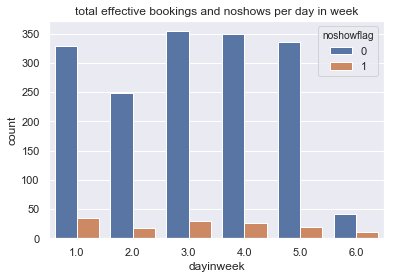

In [77]:
plt.title("total effective bookings and noshows per day in week")
ax = sns.countplot(x="dayinweek",hue="noshowflag",data=df2)

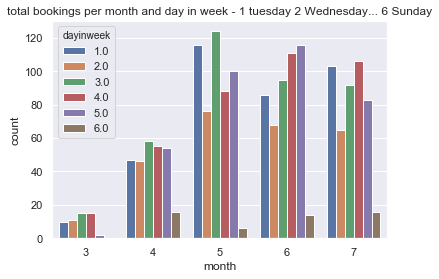

In [78]:
plt.title("total bookings per month and day in week - 1 tuesday 2 Wednesday... 6 Sunday")
ax = sns.countplot(x="month",hue="dayinweek",data=df2[df2.dayinweek!=0])

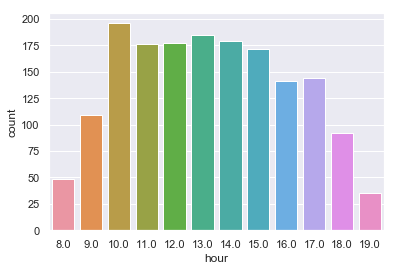

In [79]:
ax = sns.countplot(x="hour",data=df2[df2.noshowflag==0])

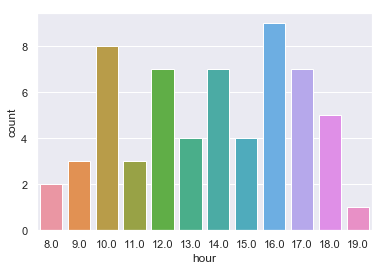

In [80]:
ax = sns.countplot(x="hour",data=df2[df2.noshowflag==1])

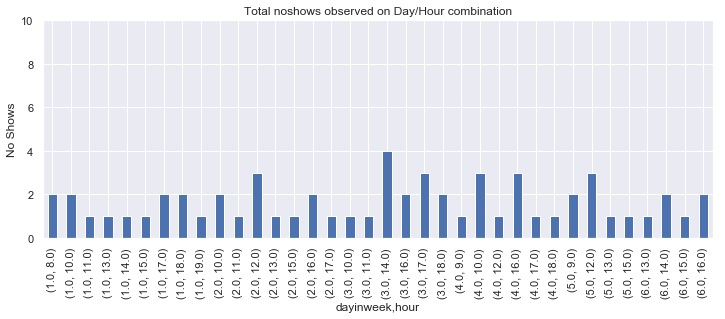

In [81]:
dftmp = df2[(df2.noshowflag==1)].copy()
slot=dftmp.groupby(['dayinweek','hour']).count() 
slot=slot['noshowflag']

plt.figure(figsize=(12,4))
plt.title("Total noshows observed on Day/Hour combination")
plt.ylabel("No Shows")
plt.ylim(0,10)
slot.plot.bar()

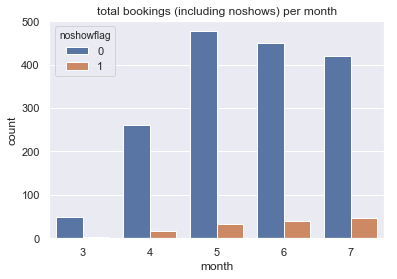

In [82]:
plt.title("total bookings (including noshows) per month")
ax = sns.countplot(x="month",hue="noshowflag",data=df2)

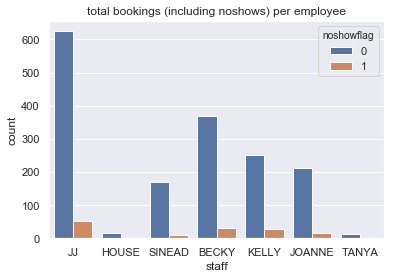

In [83]:
plt.title("total bookings (including noshows) per employee")
ax = sns.countplot(x="staff",hue="noshowflag",data=df2)

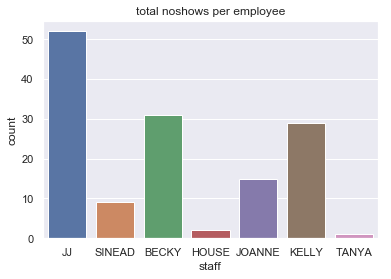

In [84]:
plt.title("total noshows per employee")
ax = sns.countplot(x="staff",data=df2[df2.noshowflag==1])

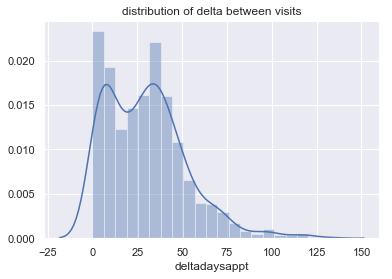

In [85]:
plt.title("distribution of delta between visits")
ax = sns.distplot(df2.loc[(df2.newcustomer==0) & df2.deltadaysappt.notnull(),'deltadaysappt'])

In [86]:
df2['dayhourcombi']='day-'+df2['dayinweek'].astype(str)+' hour-'+df2['hour'].astype(str)
dfg=df2.groupby(['dayhourcombi'])
df3=pd.DataFrame(dfg['dayinweek'].count())
df3.columns=['dayhourcount']
dfinal=pd.merge(df2,df3['dayhourcount'],on='dayhourcombi',how='left')

In [87]:
dfg=df2.groupby(['dayinweek'])
df3=pd.DataFrame(dfg['hour'].count())
df3.columns=['daycount']
#dfinal.columns
dfinal2=pd.merge(dfinal,df3['daycount'],on='dayinweek',how='left')

In [88]:
dfinal2['hourday']=None
df=dfinal2.copy()
df['hourday']=df['dayhourcount']/df['daycount']
df['hourday']=df['hourday']+(df['dayinweek'].astype('str').astype('float')/1000000)
df['hourday']=df['hourday']+(df['hour'].apply(lambda x: x if pd.notnull(x) else 1)/100000)
dfinal2['hourday']=df['hourday']
dfinal2.columns

Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate', 'canceledby',
       'latecancellation', 'tdate', 'month', 'week', 'dayinweek', 'ttime',
       'hour', 'firstapp', 'newcustomer', 'existingcustomer', 'firstdate',
       'firstdate2', 'deltadaysappt', 'deltadayslastnoshow', 'last60dvisit',
       'multipleappt', 'previousnoshow', 'last60dnoshow', 'lastnoshowdate',
       'lastnoshowhour', 'lastnoshowdayinweek', 'lastvisitdate',
       'lastvisitdayinweek', 'lastvisithour', 'laststaff', 'lastservice',
       'lastcategory', 'last60dbillamt', 'last60drefundamt', 'last60misc',
       'last60dcolor', 'last60dstyle', 'last60dproduct', 'last90dproductbuyer',
       'activebundlepromo', 'last60dlatecancel', 'last60dregcancel',
       'dayhourcombi', 'dayhourcount', 'daycount', 'hourday'],
      dtype='object')

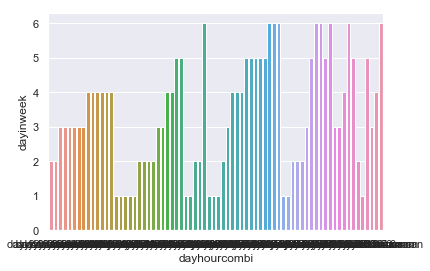

In [89]:
ax = sns.barplot(x="dayhourcombi",y="dayinweek",data=dfinal2,ci=None)

In [90]:
df2=dfinal2.groupby('dayhourcombi').first()
df2.dtypes
apptstats=df2[['dayinweek','hour','daycount','dayhourcount','hourday']]
apptstats=apptstats.reset_index()

In [91]:
lastvisitdayhour=[]
lastnoshowdayhour=[]
for row in dfinal2.itertuples():
    
    if (math.isnan(row.lastvisitdayinweek)) or (row.lastvisitdayinweek==-1):
        lastvisitdayhour.append('NA')
    else:
        if not math.isnan(row.lastvisithour):
            dh=apptstats.loc[(apptstats.hour==row.lastvisithour) & (apptstats.dayinweek==row.lastvisitdayinweek),'dayhourcombi']
        else:
            dh=apptstats.loc[(apptstats.hour.isnull()) & (apptstats.dayinweek==row.lastvisitdayinweek),'dayhourcombi']
        lastvisitdayhour.append(dh.iloc[0])
    if (math.isnan(row.lastnoshowdayinweek)) or (row.lastnoshowdayinweek==-1):
        lastnoshowdayhour.append('NA')
    else:
        if not math.isnan(row.lastnoshowhour):
            dh2=apptstats.loc[(apptstats.hour==row.lastnoshowhour) & (apptstats.dayinweek==row.lastnoshowdayinweek),'dayhourcombi']
        else:
            dh2=apptstats.loc[(apptstats.hour.isnull()) & (apptstats.dayinweek==row.lastnoshowdayinweek),'dayhourcombi']
        lastnoshowdayhour.append(dh2.iloc[0])
dfinal2['lastvisitdayhourcombi']=lastvisitdayhour
dfinal2['lastnoshowdayhourcombi']=lastnoshowdayhour

In [92]:
dfinal2.to_sql('bookingtmp4',db,if_exists='replace',index=False)

<h4> building unique identifier for each service

In [93]:
# services were sold
query="""select service,description,type,count(1) nb,SUM(amount) 'svcamt',avg(amount) 'svcavg'  from vreceipt where type='S' group by service order by svcamt desc """
services=readSQL(query)
services.head()

,service,description,type,nb,svcamt,svcavg
0,SHCW,Women's hair cut,S,651,50425.7,77.458833
1,SHCM,Men's hair cut,S,374,16725.0,44.719251
2,SBD,Blowdry,S,268,11879.0,44.324627
3,CTU,Color touch up,S,83,5230.0,63.012048
4,CHLPL,Highlights partial,S,36,5075.0,140.972222


In [94]:
#total service revenue $108,700
total_service_revenue=services['svcamt'].sum()
total_service_revenue

108669.7

In [95]:
query="""select a.*, svcavg, 
CASE a.lastservice
WHEN 'NO' THEN 0
ELSE c.lastsvcavg END as lastsvcavg
from bookingtmp4 a
left join (select service, avg(amount) svcavg from vreceipt  group by service) b on a.service=b.service
left join (select service, avg(amount) lastsvcavg from vreceipt  group by service) c on a.lastservice=c.service"""
df=readSQL(query)
len(df)

1794

In [96]:
df['lastcategory2']=df['lastcategory']
df.loc[df.lastcategory.isnull(),'lastcategory2']='NA'
df['laststaff2']=df['laststaff']
df.loc[df.laststaff.isnull(),'laststaff2']='NA'

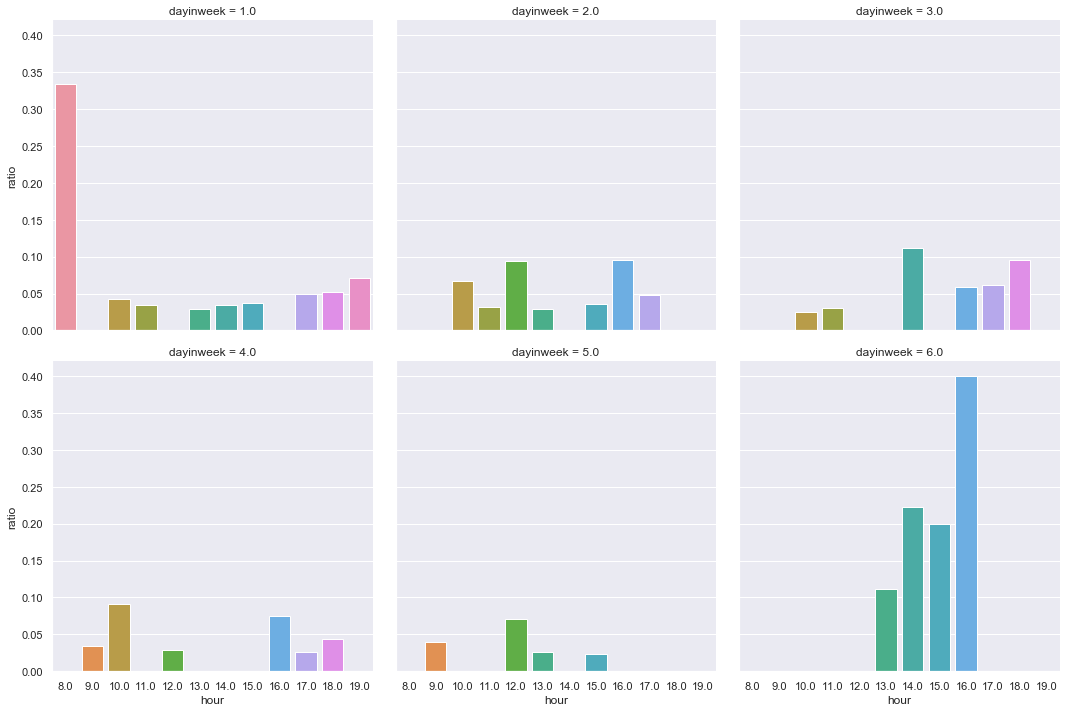

In [97]:
df6=df[['hour','dayinweek','noshowflag']].groupby(['dayinweek','hour'])
df7=df6[['noshowflag']].sum()/df6[['noshowflag']].count()
df7.columns=['ratio']
df8=df7.copy()
df8.reset_index(['dayinweek','hour'],inplace=True)

ax= sns.catplot(x="hour",y="ratio", col="dayinweek",col_wrap=3,sharex=True,
                 data=df8, kind="bar",
                 height=5, aspect=1)

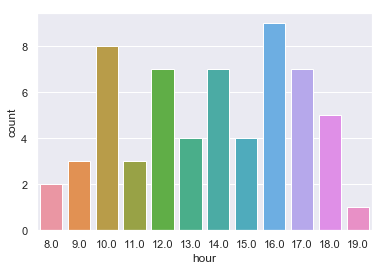

In [98]:
ax = sns.countplot(x="hour",data=df[(df.noshowflag==1)])

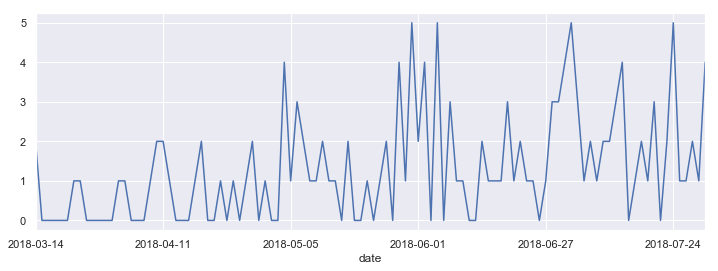

In [99]:
df2=df.copy()
df2=df2.set_index(df2['date'])
plt.figure(figsize=(12,4))
df2['noshowflag'].groupby(['date']).sum().plot();
df2=None

In [100]:
from sklearn.preprocessing import OneHotEncoder
df1hot=df[['dayhourcombi','category','service','staff']].copy()
enc = OneHotEncoder(handle_unknown='ignore')
hotarray=enc.fit_transform(df1hot.values).toarray()

In [101]:
dftmp = pd.DataFrame (enc.get_feature_names())
filepath = "C:/Users/moshe/Documents/projectML/p1/data/interim/onehotengineeredpredictors.xlsx"
dftmp.to_excel(filepath, index=False)

In [102]:
dftmp=pd.DataFrame(hotarray,columns=enc.get_feature_names())
superbooking=pd.concat([df,dftmp],axis=1)
superbooking['visit']=1

In [103]:
superbooking.to_sql('superbooking0',db,if_exists='replace',index=False)
db.commit()
superbooking.columns

C:\Users\moshe\Anaconda3\lib\site-packages\pandas\core\generic.py:2522: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


Index(['client', 'staff', 'service', 'date', 'time', 'timeint', 'description',
       'category', 'noshowflag', 'canceldate',
       ...
       'x2_SMO', 'x2_TRE 1', 'x3_BECKY', 'x3_HOUSE', 'x3_JJ', 'x3_JOANNE',
       'x3_KELLY', 'x3_SINEAD', 'x3_TANYA', 'visit'],
      dtype='object', length=170)

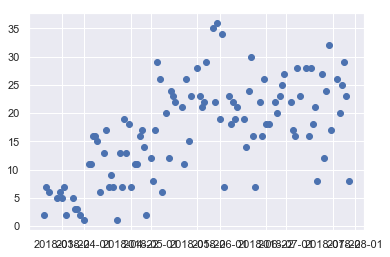

In [104]:
xs = matplotlib.dates.date2num(fbooking2.tdate.unique())
fbooking2.tdate.value_counts().sort_index()
plt.plot_date(xs,fbooking2.tdate.value_counts().sort_index())
plt.show()